<a href="https://colab.research.google.com/github/varaah/email-classification-project/blob/main/CWB_2024_Barclays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CWB 2024 Barclays Problem Statement: Email Classification Prediction

# 01 | Preparation

In [1]:
# Setting output text to wrapped
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Import libraries
import re
import nltk
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Mount gdrive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Setting parameter
min_char_email = 200   # Min characters in an email (inclusive)
test_size = 0.2     # Fraction of corpus to keep back for testing

# 02 | Data Loading

We use the Enron email dataset for the project. The dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. The source link is [here](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset).

In [ ]:
# Load dataset
df_raw = pd.read_csv("gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/data/emails.csv")
df_raw.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


The dataset include two columns:`file` and `message`. The `message` column contains the full raw email text including headers and the body.

In [ ]:
# Message sample
print(df_raw.iloc[0]['message'])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


We will break down the `message` column and extract relevant information for each email, including message ID, data, sender information, recipients information, subject, MIME version, content type, folder, filename, and the text message. We will utilise regex to do the extraction.

In [ ]:
import re

# Function to extract fields using regular expressions
def extract_email_fields(message):
    fields = {
        'Message-ID': re.search(r'Message-ID:\s(.*)', message),
        'Date': re.search(r'Date:\s(.*)', message),
        'From': re.search(r'From:\s(.*)', message),
        'X-From': re.search(r'X-From:\s(.*)', message),
        'To': re.search(r'To:\s(.*)', message),
        'X-To': re.search(r'X-To:\s(.*)', message),
        'X-cc': re.search(r'X-cc:\s(.*)', message),
        'X-bcc': re.search(r'X-bcc:\s(.*)', message),
        'Subject': re.search(r'Subject:\s(.*)', message),
        'Mime-Version': re.search(r'Mime-Version:\s(.*)', message),
        'Content-Type': re.search(r'Content-Type:\s(.*)', message),
        'Content-Transfer-Encoding': re.search(r'Content-Transfer-Encoding:\s(.*)', message),
        'X-Folder': re.search(r'X-Folder:\s(.*)', message),
        'X-Origin': re.search(r'X-Origin:\s(.*)', message),
        'X-FileName': re.search(r'X-FileName:\s(.*)', message),
        'Text': re.search(r'X-FileName:.*?\n\n(.*)', message, re.DOTALL)
    }
    # Extract and clean the found fields
    extracted = {key: (match.group(1).strip() if match else None) for key, match in fields.items()}
    return extracted

In [ ]:
# Apply the extraction function to the dataframe
extracted_data = df_raw['message'].apply(extract_email_fields)

# Create a new dataframe with the extracted fields
df_extracted = pd.DataFrame(extracted_data.tolist())

# Display the first few rows of the extracted dataframe
df_extracted.head()

,Message-ID,Date,From,X-From,To,X-To,X-cc,X-bcc,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-Folder,X-Origin,X-FileName,Text
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,,,,1.0,text/plain; charset=us-ascii,7bit,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,john.lavorato@enron.com,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,Re:,1.0,text/plain; charset=us-ascii,7bit,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,leah.arsdall@enron.com,Leah Van Arsdall,,,Re: test,1.0,text/plain; charset=us-ascii,7bit,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,randall.gay@enron.com,Randall L Gay,,,,1.0,text/plain; charset=us-ascii,7bit,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s..."
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,greg.piper@enron.com,Greg Piper,,,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.


In [ ]:
# Output extracted dataset to csv
df_extracted.to_csv("gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/data/emails_extracted.csv", index=False)

# 03 | Data Exploration

## Data Summary

In [ ]:
# Dataset Shape
df_extracted.shape

(517401, 16)

In [ ]:
# Dataset Info
df_extracted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Message-ID                 517401 non-null  object
 1   Date                       517401 non-null  object
 2   From                       517401 non-null  object
 3   X-From                     517401 non-null  object
 4   To                         517401 non-null  object
 5   X-To                       517401 non-null  object
 6   X-cc                       517401 non-null  object
 7   X-bcc                      517401 non-null  object
 8   Subject                    517401 non-null  object
 9   Mime-Version               517401 non-null  object
 10  Content-Type               517401 non-null  object
 11  Content-Transfer-Encoding  517401 non-null  object
 12  X-Folder                   517401 non-null  object
 13  X-Origin                   517401 non-null  

To better explore the dataset, we convert the `Date` column to datetime objects and put them in a new `Date_New` column.

In [ ]:
# Convert Date column to datetime
df_extracted['Date_New'] = pd.to_datetime(df_extracted['Date'], utc=True, errors='coerce')

# Extracted the Month
df_extracted['Month'] = df_extracted['Date_New'].dt.to_period('M')

df_extracted.head()

,Message-ID,Date,From,X-From,To,X-To,X-cc,X-bcc,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-Folder,X-Origin,X-FileName,Text,Date_New,Month
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,tim.belden@enron.com,Tim Belden <Tim Belden/Enron@EnronXGate>,,,,1.0,text/plain; charset=us-ascii,7bit,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast,2001-05-14 23:39:00+00:00,2001-05
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,john.lavorato@enron.com,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,Re:,1.0,text/plain; charset=us-ascii,7bit,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,2001-05-04 20:51:00+00:00,2001-05
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,leah.arsdall@enron.com,Leah Van Arsdall,,,Re: test,1.0,text/plain; charset=us-ascii,7bit,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,2000-10-18 10:00:00+00:00,2000-10
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,randall.gay@enron.com,Randall L Gay,,,,1.0,text/plain; charset=us-ascii,7bit,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00+00:00,2000-10
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,Phillip K Allen,greg.piper@enron.com,Greg Piper,,,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00+00:00,2000-08


## Data Visualisation

Next, we visualise the data to gain insights on the nature of the data.

**1. Distribution of emails over time:**

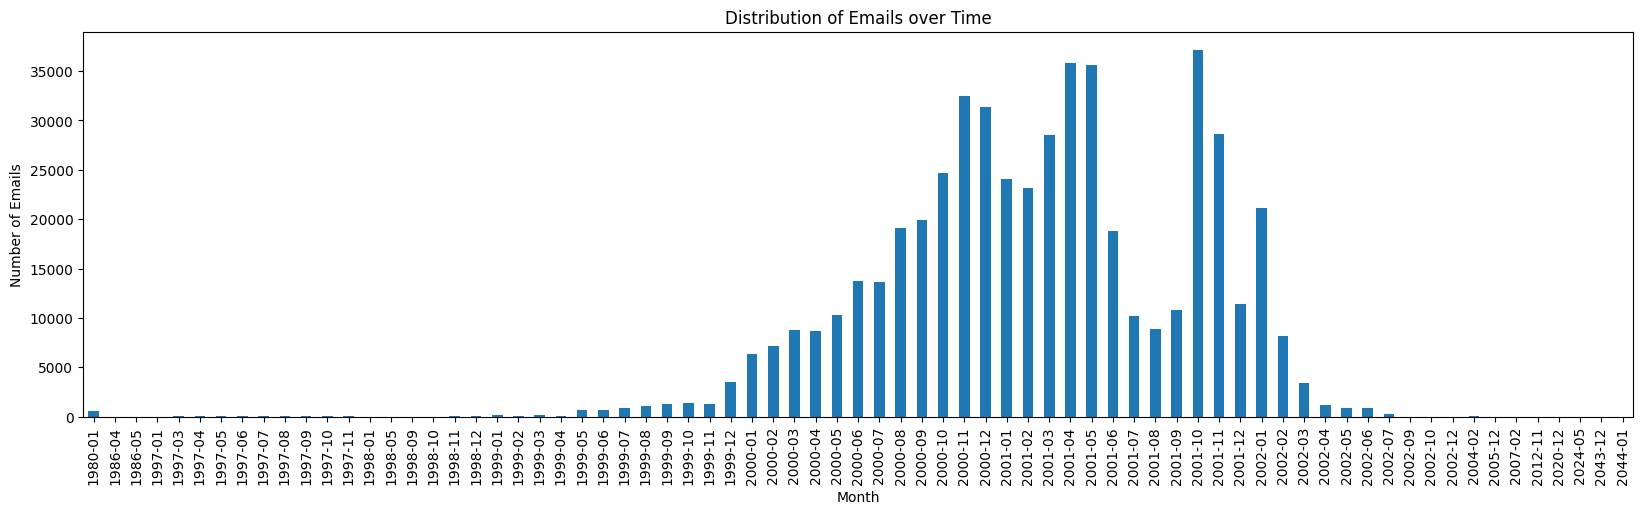

In [ ]:
# Visualise the distribution
plt.figure(figsize=(20, 5))
df_extracted.groupby(df_extracted['Month']).size().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Emails')
plt.title('Distribution of Emails over Time')
plt.show()

The email ranges from the period of 1980 Most of the emails are from the period of late 1999 to early 2002.

Also, there are some weird email that comes from the future (year 2043 and 2044). We'll remove that.

In [ ]:
# Check rows containing date in year 2043 and 2044
df_extracted[df_extracted["Month"].astype(str).str.contains('(2043|2044)', regex=True)]

,Message-ID,Date,From,X-From,To,X-To,X-cc,X-bcc,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-Folder,X-Origin,X-FileName,Text,Date_New,Month
517039,<21511287.1075842027020.JavaMail.evans@thyme>,"Mon, 4 Jan 2044 14:48:58 -0800 (PST)",cramer@cadvision.com,"""Erik Cramer"" <cramer@cadvision.com>@ENRON",john.zufferli@enron.com,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,trades,1.0,text/plain; charset=us-ascii,7bit,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,"Howdy, \nbom went out 35 at 35.5 \nFeb traded ...",2044-01-04 22:48:58+00:00,2044-01
517040,<9293997.1075842027067.JavaMail.evans@thyme>,"Mon, 4 Jan 2044 08:59:46 -0800 (PST)",cramer@cadvision.com,"""Erik Cramer"" <cramer@cadvision.com>@ENRON",john.zufferli@enron.com,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,Trades,1.0,text/plain; charset=us-ascii,7bit,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,"BOM 5th to 31st traded 34, 33.5 , 33.5 and 3...",2044-01-04 16:59:46+00:00,2044-01
517042,<15177697.1075842027136.JavaMail.evans@thyme>,"Sat, 2 Jan 2044 15:46:00 -0800 (PST)",cramer@cadvision.com,"""Erik Cramer"" <cramer@cadvision.com>@ENRON",john.zufferli@enron.com,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,trades jan 2002,1.0,text/plain; charset=us-ascii,7bit,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,feb dec trades 37.5 \nfeb dec LL went out 20 a...,2044-01-02 23:46:00+00:00,2044-01
517045,<7291254.1075842027206.JavaMail.evans@thyme>,"Mon, 28 Dec 2043 11:34:12 -0800 (PST)",cramer@cadvision.com,"""Erik Cramer"" <cramer@cadvision.com>@ENRON","linsider.jed@enron.com, john.zufferli@enron.co...","Jed Linsider <jed.linsider@mirant.com>, Zuffer...",,,marks.xls,1.0,text/plain; charset=us-ascii,7bit,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,Happy New Year !\n - marks.xls,2043-12-28 19:34:12+00:00,2043-12


In [ ]:
# Remove rows containing date in year 2043 and 2044
df_extracted = df_extracted[~df_extracted["Month"].astype(str).str.contains('(2043|2044)', regex=True)]

**2. Most Frequent Senders and Recipients:**

Most frequent senders are identified below.

In [ ]:
# Most frequent senders
top_senders = df_extracted['From'].value_counts().head(20)
top_senders

From
kay.mann@enron.com               16735
vince.kaminski@enron.com         14368
jeff.dasovich@enron.com          11411
pete.davis@enron.com              9149
chris.germany@enron.com           8801
sara.shackleton@enron.com         8777
enron.announcements@enron.com     8587
tana.jones@enron.com              8490
steven.kean@enron.com             6759
kate.symes@enron.com              5438
matthew.lenhart@enron.com         5265
eric.bass@enron.com               5158
no.address@enron.com              5112
debra.perlingiere@enron.com       4387
sally.beck@enron.com              4343
mark.taylor@enron.com             4111
susan.scott@enron.com             4000
gerald.nemec@enron.com            3888
drew.fossum@enron.com             3706
john.arnold@enron.com             3578
Name: count, dtype: int64

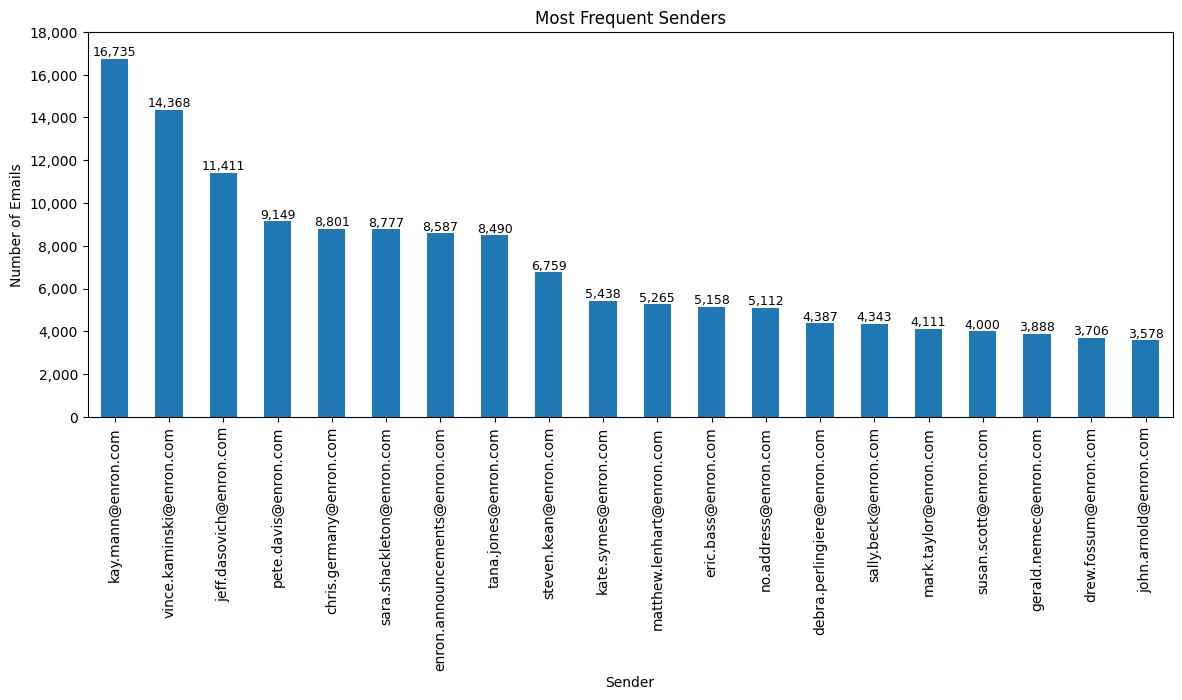

In [ ]:
# Plot the most frequent senders
plt.figure(figsize=(14, 5))
top_senders.plot(kind='bar')

# Add labels to the bars
for i, value in enumerate(top_senders):
  plt.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=9)

# Format y-axis ticks
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Sender')
plt.ylabel('Number of Emails')
plt.ylim(0, 18000)
plt.title('Most Frequent Senders')
plt.show()

Most frequent recipients are identified below.

In [ ]:
# Most frequent recipients
top_recipients = df_extracted['To'].value_counts().head(20)
top_recipients

To
                             9726
pete.davis@enron.com         9155
tana.jones@enron.com         5677
sara.shackleton@enron.com    4974
vkaminski@aol.com            4870
jeff.dasovich@enron.com      4350
kate.symes@enron.com         3517
all.worldwide@enron.com      3324
mark.taylor@enron.com        3295
kay.mann@enron.com           3085
gerald.nemec@enron.com       3074
steven.kean@enron.com        3030
louise.kitchen@enron.com     2626
sally.beck@enron.com         2550
vince.kaminski@enron.com     2404
benjamin.rogers@enron.com    2249
daren.farmer@enron.com       2064
richard.shapiro@enron.com    2027
all.houston@enron.com        1953
suzanne.adams@enron.com      1800
Name: count, dtype: int64

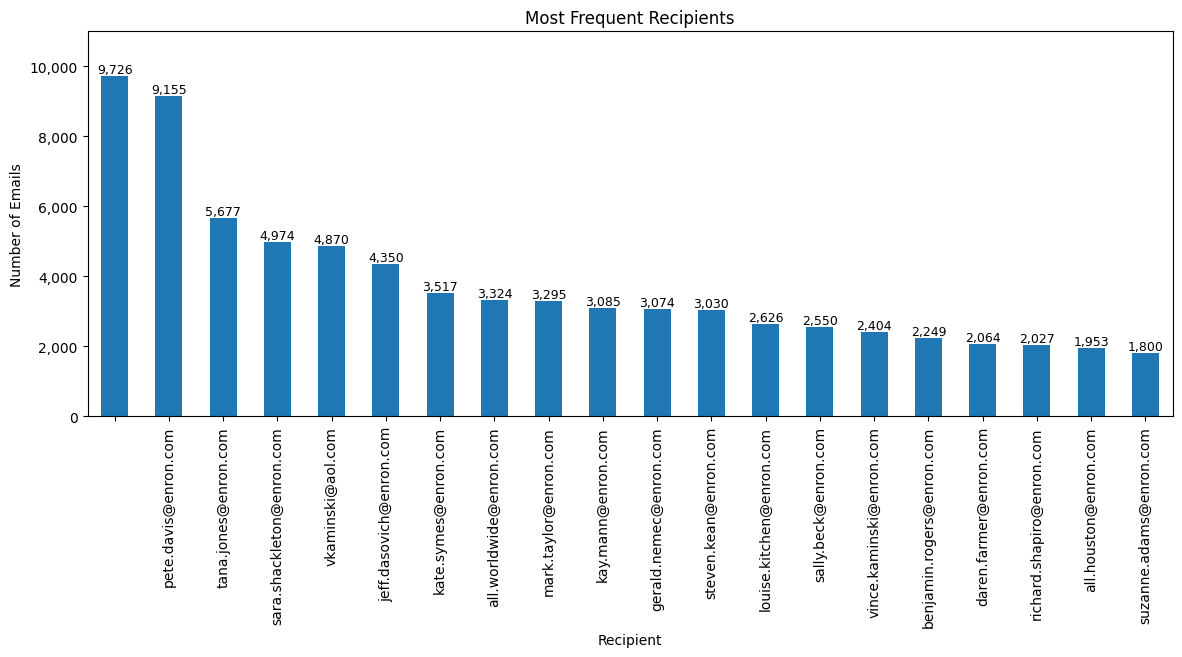

In [ ]:
# Plot the most frequent senders
plt.figure(figsize=(14, 5))
top_recipients.plot(kind='bar')

# Add labels to the bars
for i, value in enumerate(top_recipients):
  plt.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=9)

# Format y-axis ticks
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Recipient')
plt.ylabel('Number of Emails')
plt.ylim(0, 11000)
plt.title('Most Frequent Recipients')
plt.show()

We see that more than 9,000 emails does not have recipient information. We can check the rows below.

In [ ]:
# Check data with no recipient information
df_extracted[df_extracted['To'] == ''].head()

,Message-ID,Date,From,X-From,To,X-To,X-cc,X-bcc,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-Folder,X-Origin,X-FileName,Text,Date_New,Month
1230,<15816310.1075855374294.JavaMail.evans@thyme>,"Mon, 14 May 2001 17:18:42 -0700 (PDT)",outlook-migration-team@enron.com,Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,,Lee Odonnel,1.0,text/plain; charset=us-ascii,7bit,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Con...",Allen-P,pallen (Non-Privileged).pst,loan servicing-jessica weeber 800-393-5626 jwe...,2001-05-15 00:18:42+00:00,2001-05
1231,<6521706.1075855374316.JavaMail.evans@thyme>,"Mon, 14 May 2001 17:18:42 -0700 (PDT)",outlook-migration-team@enron.com,Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,,Greg Thorse,1.0,text/plain; charset=us-ascii,7bit,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Con...",Allen-P,pallen (Non-Privileged).pst,exit mccollough off 410,2001-05-15 00:18:42+00:00,2001-05
3909,<12323196.1075849626636.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 09:39:00 -0800 (PST)",jeff.youngflesh@enron.com,Jeff Youngflesh,,,,,Lexmark Document/Workflow mgmt intro,1.0,text/plain; charset=us-ascii,7bit,\John_Arnold_Nov2001\Notes Folders\All documents,ARNOLD-J,jarnold.nsf,Lexmark Solution Services intro to GSS BD. Ga...,2000-12-13 17:39:00+00:00,2000-12
4395,<111015.1075857579145.JavaMail.evans@thyme>,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",john.arnold@enron.com,John Arnold,,,,,,1.0,text/plain; charset=us-ascii,7bit,\John_Arnold_Dec2000\Notes Folders\All documents,Arnold-J,Jarnold.nsf,"To ""Outstanding"" Analysts and Associates:\nI ...",1980-01-01 00:00:00+00:00,1980-01
4442,<12093912.1075857602732.JavaMail.evans@thyme>,"Tue, 15 May 2001 10:17:00 -0700 (PDT)",ann.schmidt@enron.com,Ann M Schmidt,,,,,Enron Mentions,1.0,text/plain; charset=us-ascii,7bit,\John_Arnold_Jun2001\Notes Folders\All documents,Arnold-J,Jarnold.nsf,Dabhol lenders to vote today on PPA PPPPA term...,2001-05-15 17:17:00+00:00,2001-05


**3. Distribution of Email Subjects:**

We analyze the most common words or phrases in email subjects.

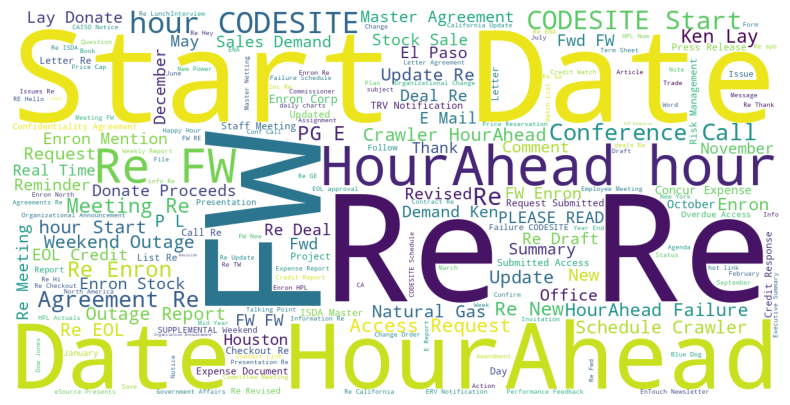

In [ ]:
# Combine all subjects into a single text
all_subjects = ' '.join(df_extracted['Subject'])

# Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(all_subjects)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**4. Folder Distribution:**

We will look into the `X-Folder` to see how we can use the data as the label to categorise the emails.

In [ ]:
# Check the number of rows
print("Number of rows:", df_extracted.shape[0])

# Check the number of unique folders
print("Number of unique folders:", df_extracted['X-Folder'].unique().shape[0])

Number of rows: 517397
Number of unique folders: 5335


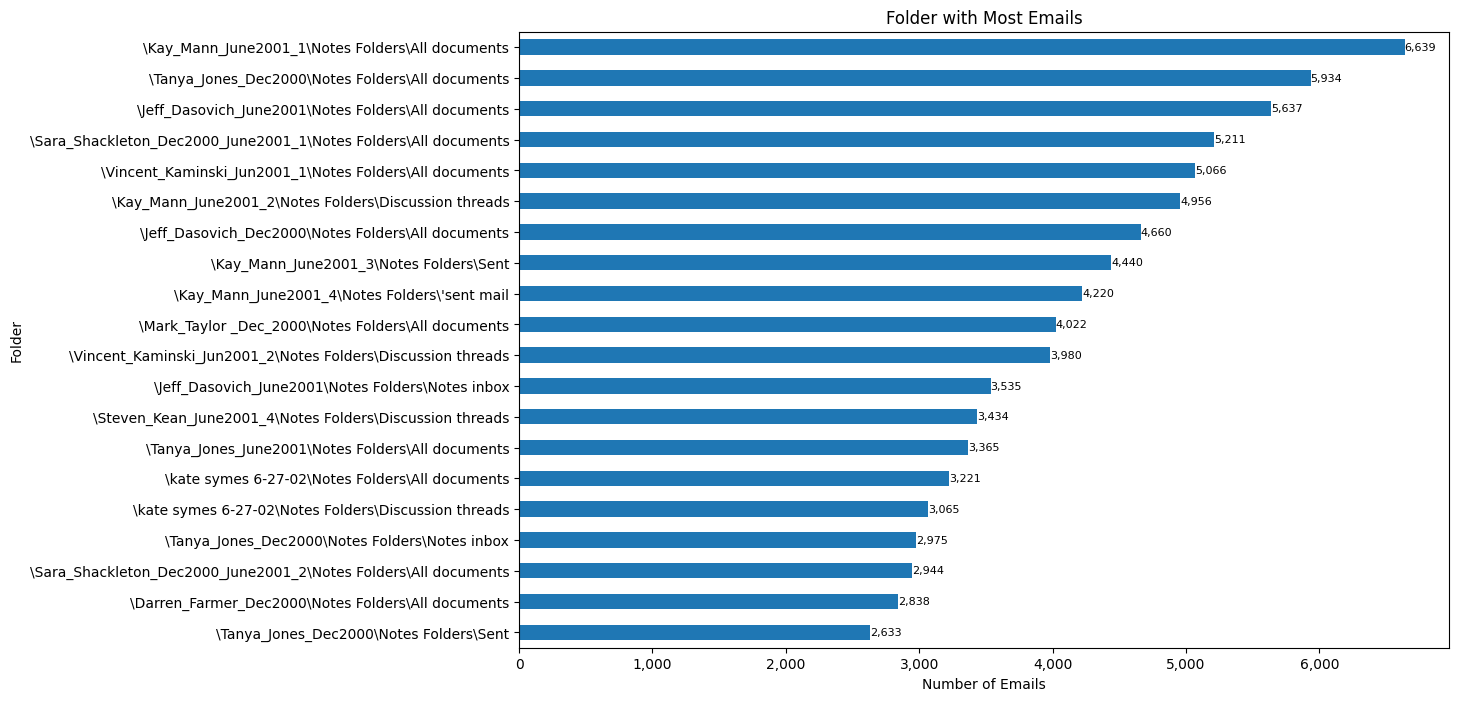

In [ ]:
# Count the number of emails in each unique folder
email_counts_per_folder = df_extracted['X-Folder'].value_counts()

# Top 20 folder with most emails
top_20_folder = email_counts_per_folder[:20]

# Plot the top 20 email count distribution
plt.figure(figsize=(12, 8))
top_20_folder.plot(kind='barh')

# Add labels to the bars
for i, value in enumerate(top_20_folder):
  plt.text(value, i, f'{value:,}', ha='left', va='center', fontsize=8)

# Format axis
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.gca().invert_yaxis()

plt.xlabel('Number of Emails')
plt.ylabel('Folder')
plt.title('Folder with Most Emails')
plt.show()

In [ ]:
# See folder name table
pd.DataFrame(email_counts_per_folder).reset_index()

,X-Folder,count
0,\Kay_Mann_June2001_1\Notes Folders\All documents,6639
1,\Tanya_Jones_Dec2000\Notes Folders\All documents,5934
2,\Jeff_Dasovich_June2001\Notes Folders\All docu...,5637
3,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,5211
4,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,5066
...,...,...
5330,\Richard_Shapiro_Nov2001\Notes Folders\Tva,1
5331,\Richard_Shapiro_June2001\Notes Folders\Traini...,1
5332,\LKITCHEN (Non-Privileged)\'Americas\RAC,1
5333,\Richard_Shapiro_Nov2001\Notes Folders\Texas,1


We see that some folders are too general to be used as labels, such as "All documents", "Sent mail", "Notes inbox", "Deleted items", etc. For data preprocessing later, we will  take the `X-Folder` path value to extract only the last folder name, clean/normalise the data, and remove the general folder name. We then use the resulted column as the label.

# 04 | Data Pre-processing

For data pre-processing, we will do the following:

1. Subset the dataset containing columns we need, including `From`, `To`, `Subject`, `Text`, `Date_New` and `X-Folder`.

2. Preprocess the `X-Folder` column for label:
* Extract the last folder name from `X-Folder` column
* Clean and normalize the folder names
* Remove folder with general names
* Select folders that have more than 100 emails

3. Combine and preprocess the feature columns, including `From`, `To`, `Subject` and `Text`columns.

## Subsetting the Dataset

First, we will subset the dataset to include only the relevant columns.

In [ ]:
df_extracted.shape

(517397, 18)

In [ ]:
# Subset the dataset
df_subset = df_extracted[['From', 'To', 'Subject', 'Text', 'X-Folder']]
df_subset.head()

,From,To,Subject,Text,X-Folder
0,phillip.allen@enron.com,tim.belden@enron.com,,Here is our forecast,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se..."
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se..."
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
3,phillip.allen@enron.com,randall.gay@enron.com,,"Randy,\n\n Can you send me a schedule of the s...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail
4,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,\Phillip_Allen_Dec2000\Notes Folders\'sent mail


## Processing Label Column

We process the `X-Folder` column for our label column.

In [ ]:
# Extract the last folder name from X-Folder
df_subset['Folder'] = df_subset['X-Folder'].apply(lambda x: x.split('\\')[-1])

# Clean and normalize the folder names
df_subset['Folder'] = df_subset['Folder'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)

# Remove rows with general folder names
general_folders = ["all documents", "deleted items", "sent", "inbox",
                   "sent items", "sent mail", "untitled", "notes inbox"]
df_filtered = df_subset[~df_subset['Folder'].isin(general_folders)]

# Filter only folders that contains more than 200 emails
df_filtered = df_filtered[df_filtered.groupby('Folder')['Folder'].transform('count') > 200].reset_index(drop=True)

# Drop the `X-Folder` column
df_filtered.drop('X-Folder', axis=1, inplace=True)
df_filtered.head()

,From,To,Subject,Text,Folder
0,outlook-migration-team@enron.com,,Lee Odonnel,loan servicing-jessica weeber 800-393-5626 jwe...,contacts
1,outlook-migration-team@enron.com,,Greg Thorse,exit mccollough off 410,contacts
2,phillip.allen@enron.com,naomi.johnston@enron.com,,"Naomi,\n\nThe two analysts that I have had con...",discussion threads
3,phillip.allen@enron.com,brenda.flores-cuellar@enron.com,eol,Jeff/Brenda:\n\nPlease authorize the following...,discussion threads
4,phillip.allen@enron.com,ina.rangel@enron.com,ENA Management Committee,---------------------- Forwarded by Phillip K ...,discussion threads


In [ ]:
# Number of rows in the resulted dataset
print("Number of rows in the resulted dataset:", df_filtered.shape[0], end= '\n\n')

# Number of unique folders
print("Number of unique folder:", df_filtered['Folder'].nunique(), end= '\n\n')

# Check the Folder column
df_filtered['Folder'].value_counts()

Number of rows in the resulted dataset: 92393

Number of unique folder: 64



Folder
discussion threads    58609
personal               2642
attachments            2026
meetings               1872
calendar               1754
                      ...  
conferences             223
rice                    210
800                     210
ctgdeals                205
portland                203
Name: count, Length: 64, dtype: int64

In the resulted dataset, there are 92.393 rows of data with 64 unique folder names that we will use as labels.

## Processing Feature Columns

First, we will concatenate the `From`, `To`, `Subject`, and `Text` columns into a single text column as the feature column.

In [ ]:
# Concatenate feature columns
df_filtered['Combined_Text'] = df_filtered[['From', 'To', 'Subject', 'Text']].fillna('').agg(' '.join, axis=1)
df_filtered.head()

,From,To,Subject,Text,Folder,Combined_Text
0,outlook-migration-team@enron.com,,Lee Odonnel,loan servicing-jessica weeber 800-393-5626 jwe...,contacts,outlook-migration-team@enron.com Lee Odonnel ...
1,outlook-migration-team@enron.com,,Greg Thorse,exit mccollough off 410,contacts,outlook-migration-team@enron.com Greg Thorse ...
2,phillip.allen@enron.com,naomi.johnston@enron.com,,"Naomi,\n\nThe two analysts that I have had con...",discussion threads,phillip.allen@enron.com naomi.johnston@enron.c...
3,phillip.allen@enron.com,brenda.flores-cuellar@enron.com,eol,Jeff/Brenda:\n\nPlease authorize the following...,discussion threads,phillip.allen@enron.com brenda.flores-cuellar@...
4,phillip.allen@enron.com,ina.rangel@enron.com,ENA Management Committee,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com ina.rangel@enron.com E...


We then continue with the text cleaning process for the `Combined_Text` column.

In [ ]:
# Text cleaning function
def clean_text(text):
  # Convert to lowercase
  text = text.lower()

  # 'Normalise' URLs by removing the https/http/www (e.g. https://www.hotmail.com -> hotmailcom)
  text = re.sub(r'https|http|www', '', text, flags=re.MULTILINE)

  # Remove @ and # characters
  text = re.sub(r'\@\w+|\#', '', text)

  # Remove non-alphabetic characters
  text = re.sub(r'[^a-z\s]', '', text)

  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()

  # Remove stopwords
  tokens = []
  for word in text.split():
     if (word not in stop_words) : tokens.append(word)

  # Lemmatise words
  lm = WordNetLemmatizer()
  stemmed_words = [lm.lemmatize(w) for w in tokens]

  # Join the cleaned words
  cleaned_text = " ".join(stemmed_words)

  return cleaned_text

In [ ]:
# Apply the text cleaning
df_filtered['Cleaned_Text'] = df_filtered['Combined_Text'].apply(clean_text)

# Sample of the cleaned text
df_filtered[[ 'Combined_Text', 'Cleaned_Text']].head()

,Combined_Text,Cleaned_Text
0,outlook-migration-team@enron.com Lee Odonnel ...,outlookmigrationteamcom lee odonnel loan servi...
1,outlook-migration-team@enron.com Greg Thorse ...,outlookmigrationteamcom greg thorse exit mccol...
2,phillip.allen@enron.com naomi.johnston@enron.c...,phillipallencom naomijohnstoncom naomi two ana...
3,phillip.allen@enron.com brenda.flores-cuellar@...,phillipallencom brendaflorescuellarcom eol jef...
4,phillip.allen@enron.com ina.rangel@enron.com E...,phillipallencom inarangelcom ena management co...


We then check the text length of the resulted `Cleaned_Text` column and filtered out rows that has less than our expected minimum characters (< 200 characters). We do this to maintain the algorithm has enough data to train the model in each row.

In [ ]:
# Create column with length of Text
df_filtered['Text_Length'] = df_filtered['Cleaned_Text'].str.len()

# Filter text for minimum characters
df_filtered = df_filtered[df_filtered['Text_Length'] > min_char_email]

df_filtered.head()

,From,To,Subject,Text,Folder,Combined_Text,Cleaned_Text,Text_Length
2,phillip.allen@enron.com,naomi.johnston@enron.com,,"Naomi,\n\nThe two analysts that I have had con...",discussion threads,phillip.allen@enron.com naomi.johnston@enron.c...,phillipallencom naomijohnstoncom naomi two ana...,327
3,phillip.allen@enron.com,brenda.flores-cuellar@enron.com,eol,Jeff/Brenda:\n\nPlease authorize the following...,discussion threads,phillip.allen@enron.com brenda.flores-cuellar@...,phillipallencom brendaflorescuellarcom eol jef...,443
4,phillip.allen@enron.com,ina.rangel@enron.com,ENA Management Committee,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com ina.rangel@enron.com E...,phillipallencom inarangelcom ena management co...,1241
5,phillip.allen@enron.com,pallen70@hotmail.com,Daily Report,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com pallen70@hotmail.com D...,phillipallencom pallencom daily report forward...,373
6,phillip.allen@enron.com,pallen70@hotmail.com,Daily Report,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com pallen70@hotmail.com D...,phillipallencom pallencom daily report forward...,374


In [ ]:
df_filtered.shape

(71484, 8)

The resulted dataset contains 71.484 rows of data.

In [ ]:
# Save cleaned dataset
df_filtered.to_csv("gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/data/emails_cleaned.csv", index=False)

# 05 | Model Building

In [5]:
# Re-load cleaned dataset
df_filtered = pd.read_csv("gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/data/emails_cleaned.csv")
df_filtered.head()

,From,To,Subject,Text,Folder,Combined_Text,Cleaned_Text,Text_Length
0,phillip.allen@enron.com,naomi.johnston@enron.com,NaN,"Naomi,\n\nThe two analysts that I have had con...",discussion threads,phillip.allen@enron.com naomi.johnston@enron.c...,phillipallencom naomijohnstoncom naomi two ana...,327
1,phillip.allen@enron.com,brenda.flores-cuellar@enron.com,eol,Jeff/Brenda:\n\nPlease authorize the following...,discussion threads,phillip.allen@enron.com brenda.flores-cuellar@...,phillipallencom brendaflorescuellarcom eol jef...,443
2,phillip.allen@enron.com,ina.rangel@enron.com,ENA Management Committee,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com ina.rangel@enron.com E...,phillipallencom inarangelcom ena management co...,1241
3,phillip.allen@enron.com,pallen70@hotmail.com,Daily Report,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com pallen70@hotmail.com D...,phillipallencom pallencom daily report forward...,373
4,phillip.allen@enron.com,pallen70@hotmail.com,Daily Report,---------------------- Forwarded by Phillip K ...,discussion threads,phillip.allen@enron.com pallen70@hotmail.com D...,phillipallencom pallencom daily report forward...,374


## Splitting Dataset

Before training the model, we split the dataset into training and testing dataset. The proportion of training and testing split is 80:20.

In [18]:
# Split the dataset
X = df_filtered['Cleaned_Text']
y = df_filtered['Folder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)

## Model Training

To train supervised classifiers, we also need to transform the text into a vector of numbers. We use `Bag of Words` as our vector representations method. We will use the Pipeline to build a sequence of steps to process the data and train the model.

In [19]:
# Build the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [20]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(max_features=5000)),
                ('classifier', LogisticRegression(max_iter=1000))])

## Model Prediction

In [21]:
# Model prediction
y_pred_lr_bow = pipeline.predict(X_test)
y_pred_lr_bow

array(['discussion threads', 'discussion threads', 'twcommercial group',
       ..., 'discussion threads', 'discussion threads', 'portland'],
      dtype=object)

In [22]:
# Add the prediction result to a new dataframe containing x_test, y_test, and y_pred_lr_bow
df_pred = pd.DataFrame({'x_test': X_test, 'y_test': y_test, 'y_pred_lr_bow': y_pred_lr_bow})
df_pred.head()

,x_test,y_test,y_pred_lr_bow
28603,vasantshanbhoguecom vincekaminskicom subject h...,discussion threads,discussion threads
65819,janetholtcom jhemmerlycom imbalance charge web...,discussion threads,discussion threads
43652,jefferyfawcettcom lorrainelindbergcom account ...,discussion threads,twcommercial group
70579,petedaviscom petedaviscom start date hourahead...,schedule crawler,schedule crawler
53145,robinrodriguecom beckypitrecom mom bday though...,discussion threads,discussion threads


In [24]:
# Save the predictions
df_pred.to_csv('gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/output/lr_bow_predictions.csv', index=False)

# 06 | Model Evaluation

In [35]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr_bow)
classification_rep = classification_report(y_test, y_pred_lr_bow)

# Model evaluation result
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_lr_bow))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_lr_bow, average='weighted')), end='\n\n')

Testing accuracy 0.6483877736588095
Testing F1 score: 0.6352855212526619



In [36]:
print('Testing classification report:')
print(classification_report(y_test, y_pred_lr_bow))

Testing classification report:
                     precision    recall  f1-score   support

            24 hour       0.41      0.25      0.31        36
                800       0.54      0.46      0.50        28
           archives       0.71      0.64      0.67        69
           articles       0.30      0.19      0.24        52
        attachments       0.16      0.14      0.15       339
  bill williams iii       0.74      0.65      0.69       170
           calendar       0.79      0.62      0.69       104
         california       0.10      0.10      0.10       189
  california issues       0.64      0.48      0.55        63
                ces       0.18      0.16      0.17       114
        conferences       0.13      0.14      0.13        44
    connect deletes       0.06      0.03      0.04        66
           contacts       1.00      0.43      0.60         7
          corporate       0.12      0.07      0.08        90
     corporate comm       0.00      0.00      0.00   

In [37]:
# Saving the model using joblib
filename = "gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/output/lr_bow_model.sav"
joblib.dump(pipeline, filename)

['gdrive/MyDrive/Projects/Project/CWB 2024 Barclays/output/lr_bow_model.sav']

Evaluation of the model shows a testing accuracy of 64.84%. In the future, we can try to further improve the model performance by improving the pre-processing stage, trying different model algorithm, or tuning the parameter in the model training.